## Transfer Learning

In this notebook, we will used pretrained network VGG to classify flower dataset

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available, Training on CPU...')
else:
    print('CUDA is available, Training on GPU...')

CUDA is available, Training on GPU...


#### Load  our data

In [3]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Transforming the data

In [4]:
# load and transform data using Imagefolder

#vgg16 takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print("Num of train images: ", len(train_data))
print("Num of test images: ", len(test_data))

Num of train images:  3130
Num of test images:  540


#### DataLoaders and Data Visualization

In [5]:
# define dataloaders parameters
batch_size = 20
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [6]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

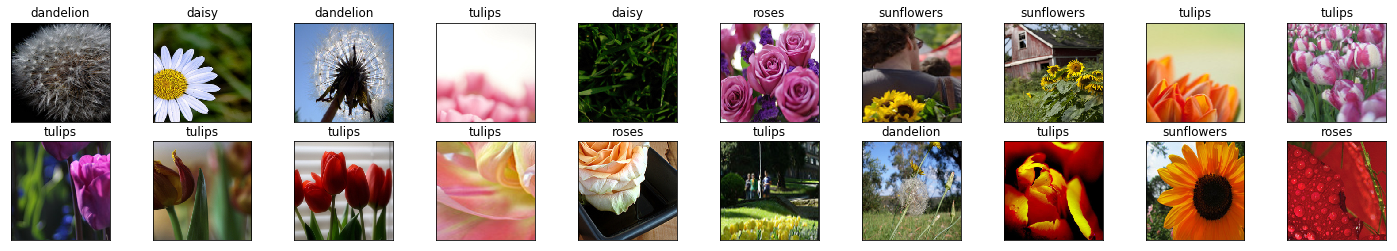

In [7]:
# plot the images in batch
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#### Define the model

To define a model for training, here are the steps:
1. load in a pretrained VGG16 model
2. freeze all parameters, `freezing means the parameters in model will not change during training` so the network acts as a feature extractor
3. remove the last layer
4. replace the last layer with a linear classifier of your own

In [8]:
# Load vgg16 model
vgg16 = models.vgg16(pretrained=True)

# print out model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
1000


In [10]:
# Freeze training for all features layers
for param in vgg16.features.parameters():
    param.requires_grad = False

#### Final Classifier Layer

In [11]:
import torch
from torch import nn
from torch import optim

# We will replace the last layer

in_features = vgg16.classifier[6].in_features

last_layer = nn.Linear(in_features, len(classes))

vgg16.classifier[6] = last_layer

if train_on_gpu:
    vgg16.cuda()

In [12]:
# specify loss function and optimimzer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

#### Training the network

In [13]:
n_epochs = 2

for e in range(n_epochs):
    training_loss = 0
    for batch_i, (images, labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = vgg16(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (e+1, batch_i + 1, training_loss / 20))
            training_loss = 0.0

        
        

Epoch 1, Batch 20 loss: 1.5918902099132537
Epoch 1, Batch 40 loss: 1.3862239122390747
Epoch 1, Batch 60 loss: 1.2441163003444671
Epoch 1, Batch 80 loss: 1.1428591817617417
Epoch 1, Batch 100 loss: 1.0934536218643189
Epoch 1, Batch 120 loss: 1.0049511641263962
Epoch 1, Batch 140 loss: 0.9810125321149826
Epoch 2, Batch 20 loss: 0.8738442182540893
Epoch 2, Batch 40 loss: 0.8524539709091187
Epoch 2, Batch 60 loss: 0.8327398926019669
Epoch 2, Batch 80 loss: 0.8615253418684006
Epoch 2, Batch 100 loss: 0.8128168791532516
Epoch 2, Batch 120 loss: 0.7821078538894654
Epoch 2, Batch 140 loss: 0.7754062652587891


#### Testing the network

In [17]:
# track test loss
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for images, labels in test_loader:
    # move tensors to gpu if cuda is available
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    #forward pass
    output = vgg16(images)
    # calculate batch loss
    loss = criterion(output, labels)
    # update test loss
    test_loss += loss.item()*images.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.726801

Test Accuracy of daisy: 75% (69/92)
Test Accuracy of dandelion: 93% (124/132)
Test Accuracy of roses: 64% (59/91)
Test Accuracy of sunflowers: 63% (64/101)
Test Accuracy of tulips: 71% (89/124)

Test Accuracy (Overall): 75% (405/540)


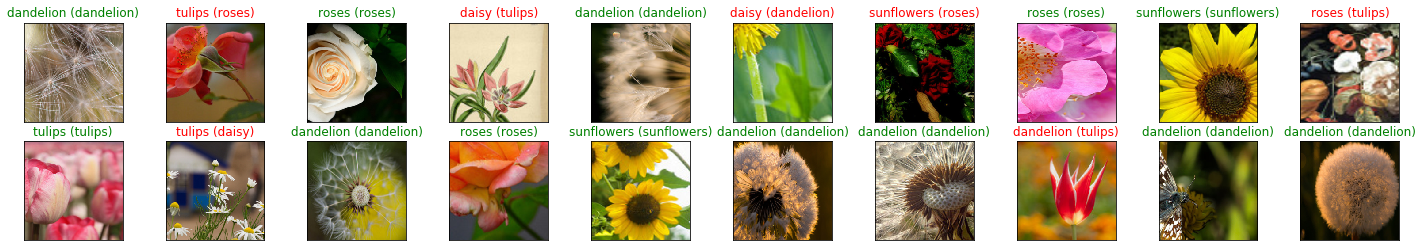

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))